In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import glob, sys
import pickle

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import *
from plotting_utils import *
from lineplots import plotsd
from stabilizer_utils import *
from recalibration_utils import *
from session_utils import *

from CosineTuning import *

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis

min_nblocks    = 2
participant    = 'T5'


FILE_DIR       = '/oak/stanford/groups/henderj/ghwilson/nonstationarities/' + participant + '/'
fig_path       = '/home/users/ghwilson/projects/nonstationarities/figures/'
filelist       = glob.glob(FILE_DIR + 'historical/*')
filelist.extend(glob.glob(FILE_DIR + 'new/*'))

block_constraints = getBlockConstraints(FILE_DIR)

files          = get_Sessions(filelist, min_nblocks,  block_constraints = block_constraints)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from joblib import Parallel, delayed
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import warnings


def search_regularization(reg_opts, x_train, y_train):
    
    tuned_params = {'alpha' : reg_opts}
    clf          = GridSearchCV(Ridge(), tuned_params).fit(x_train, y_train)
    
    return clf.best_estimator_


def train_decoders(train_x, train_y, test_x, test_y, cfg):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        decoder      = search_regularization(cfg['reg_opts'], train_x, train_y)
        score        = decoder.score(test_x, test_y)
    
    return decoder, score



def processSingleSession(file, cfg):
    
    n_restarts   = 10
    session_dict = dict()
    fields       = ['TX', 'cursorPos', 'targetPos']
    
    # First calculate encoding and decoding weights independently for each session:
    session = DataStruct(file, causal_filter = cfg['sigma'], alignScreens = True)
    blocks  = block_constraints[file]

    # obtain features and cursorError targets:
    session_dat = getTrainTest(session, fields = fields, train_size = cfg['train_size'], 
                               task = cfg['task'], blocks = blocks, returnFlattened = True) 
    session_dict['decoder_means'] = session_dat['test_TX'][-1].mean(axis = 0)
    
    train_y = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y  = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])
    train_x, test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'], method = 'blockwise', concatenate = True)

    # ===== train decoders ======
    scores = dict()
    for dim in cfg['FA_dims']:
        fas      = list()
        logprobs = list()
        for i in range(n_restarts):
            fa = FactorAnalysis(n_components=dim, random_state=i).fit(train_x)
            log_p = fa.score(train_x)
            fas.append(fa)
            logprobs.append(log_p)

        fa = fas[np.argmax(logprobs)]
        train_latent = fa.transform(train_x)
        test_latent  = fa.transform(test_x)
        
        _,    score = train_decoders(train_latent, train_y, test_latent, test_y, cfg)
        scores[dim] = score
    
    return scores

In [4]:
# general settings:
np.random.seed(42)
cfg = dict()

cfg['task']         = None
cfg['train_size']   = 0.5
cfg['sigma']        = 2
cfg['reg_opts']     = [1e1, 1e3, 1e5, 1e7, 1e9]
cfg['FA_dims']      = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 192]

# --------------------------------------------------
#dict_list = list()
#for file in files:
#    dict_list = processSingleSession(file, cfg) 
#    print(file)

dict_list    = Parallel(n_jobs=10, verbose = 11)(delayed(processSingleSession)(file, cfg) for file in files)
session_dict = dict()

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   0 out of   0 | elapsed:    0.0s finished


In [14]:
import pickle

with open('chaofei_data.pkl', 'wb') as f:
    pickle.dump(f, dict_list)

TypeError: file must have a 'write' attribute

#### Test rolling adaptation vs blockwise 

In [23]:
from joblib import Parallel, delayed
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import warnings

def processSingleSession(file, cfg):
    
    session_dict = dict()
    fields       = ['TX', 'cursorPos', 'targetPos']
    
    # First calculate encoding and decoding weights independently for each session:
    session = DataStruct(file, causal_filter = cfg['sigma'], alignScreens = True)
    blocks  = block_constraints[file]

    # obtain features and cursorError targets:
    session_dat = getTrainTest(session, fields = fields, train_size = cfg['train_size'], 
                               task = cfg['task'], blocks = blocks, returnFlattened = True) 
    
    train_y = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y  = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])
    train_x, test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'], method = 'blockwise', concatenate = True)
    
    #train_x_rolling, test_x_rolling = subtractMeans(session_dat['train_TX'], session_dat['test_TX'], method = 'rolling', concatenate = False)
    #train_x_rolling, test_x_rolling = rollingZScore(train_x_rolling, test_x_rolling, concatenate = True)

    scores = [LinearRegression().fit(train_x, train_y).score(test_x, test_y),
              LinearRegression().fit(train_x_rolling, train_y).score(test_x_rolling, test_y)]
    
    return scores


def rollingZScore(train_x, test_x, window_size=600, concatenate=False):
    '''Apply moving average z-score based on past time window.'''
    
    train_x_new, test_x_new = list(), list()
    subtract = [train_x[-1]] + test_x

    for i, x in enumerate(train_x):
        pad_val      = np.std(x, axis = 0)
        running_std  = np.std(rolling_window(x, window_size = 600, padding = pad_val), axis = 1) 
        x_rolling    = x / (running_std + 1)
        train_x_new.append(x_rolling)

    for i, x in enumerate(test_x):
        pad_val      = np.std(subtract[i][:-window_size, :], axis = 0)
        running_std  = np.std(rolling_window(x, window_size = 600, padding = pad_val), axis = 1) 
        x_rolling    = x / (running_std + 1)
        test_x_new.append(x_rolling)
        
    train_x = train_x_new
    test_x  = test_x_new
        
    if concatenate:
        train_x = np.concatenate(train_x)
        test_x  = np.concatenate(test_x) if test_x != [] else []
        
    return train_x, test_x


# general settings:
np.random.seed(42)
cfg = dict()

cfg['task']         = None
cfg['train_size']   = 0.5
cfg['sigma']        = 2

# --------------------------------------------------
#dict_list = list()
#for file in files:
#    dict_list = processSingleSession(file, cfg) 
#    print(file)

dict_list    = Parallel(n_jobs=2, verbose = 11)(delayed(processSingleSession)(file, cfg) for file in files)
session_dict = dict()

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   36.7s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:   49.6s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:  3.5min
[Parallel(

In [31]:
struct = DataStruct(files[14], causal_filter=2)

Text(0, 0.5, 'Rolling')

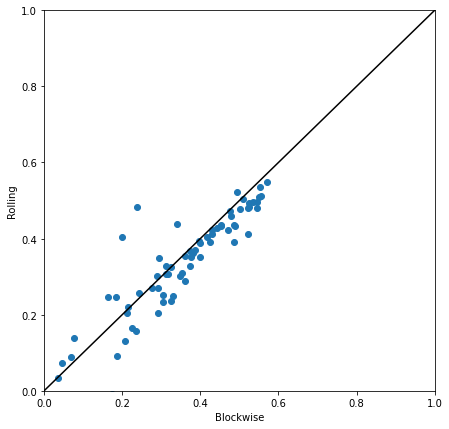

In [24]:
figSize(7,7)

scores = np.vstack(dict_list)

plt.scatter(scores[:, 0], scores[:, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0,1],[0,1], c='k')
plt.xlabel('Blockwise')
plt.ylabel('Rolling')

In [23]:
for d, file in zip(dict_list, files):
    d['session'] = file


In [25]:
import pandas as pd

df = pd.DataFrame(dict_list)

In [27]:
df.to_csv('fa_cursor_data.csv')

In [29]:
pd.read_csv('fa_cursor_data.csv')

,Unnamed: 0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,45,50,192,session
0,0,0.138579,0.413367,0.404535,0.427668,0.430377,0.430507,0.430922,0.427713,0.431500,0.438392,0.435986,0.438594,0.437209,0.433580,0.436603,0.434876,0.430605,/oak/stanford/groups/shenoy/ghwilson/nonstatio...
1,1,0.174881,0.224889,0.317224,0.340125,0.368528,0.376638,0.364974,0.376591,0.366677,0.383732,0.377913,0.373124,0.381021,0.372436,0.359754,0.353648,0.399082,/oak/stanford/groups/shenoy/ghwilson/nonstatio...
2,2,0.241399,0.213379,0.330650,0.344380,0.373362,0.395498,0.392279,0.395870,0.397200,0.393770,0.401784,0.398020,0.402972,0.402471,0.401737,0.394091,0.417768,/oak/stanford/groups/shenoy/ghwilson/nonstatio...
3,3,0.225431,0.397557,0.399517,0.405149,0.411118,0.410022,0.414001,0.424194,0.425838,0.422883,0.424678,0.422168,0.421567,0.422463,0.425232,0.423509,0.424254,/oak/stanford/groups/shenoy/ghwilson/nonstatio...
4,4,0.269152,0.488276,0.498305,0.517048,0.528786,0.532135,0.532102,0.541353,0.538908,0.542534,0.539604,0.539431,0.539599,0.541415,0.539439,0.539250,0.548278,/oak/stanford/groups/shenoy/ghwilson/nonstatio...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,68,-0.010429,0.135760,0.277893,0.274457,0.286245,0.290772,0.295132,0.275468,0.280065,0.283726,0.282842,0.238442,0.285872,0.280317,0.275991,0.257304,0.300005,/oak/stanford/groups/shenoy/ghwilson/nonstatio...
69,69,-0.057668,0.146195,0.179665,0.195296,0.217978,0.217580,0.228504,0.229748,0.228526,0.234865,0.232085,0.191784,0.200726,0.194602,0.216484,0.220803,0.224752,/oak/stanford/groups/shenoy/ghwilson/nonstatio...
70,70,0.032831,0.334811,0.332596,0.348247,0.359865,0.362138,0.364511,0.365026,0.370268,0.364952,0.365470,0.340531,0.341287,0.351263,0.351291,0.358107,0.364311,/oak/stanford/groups/shenoy/ghwilson/nonstatio...
71,71,-0.005282,0.090782,0.219756,0.220108,0.218873,0.212036,0.224089,0.217511,0.216774,0.247076,0.231284,0.231297,0.220371,0.232549,0.225395,0.230671,0.237713,/oak/stanford/groups/shenoy/ghwilson/nonstatio...


In [12]:
normalized_scores = np.zeros(((len(uniqueFiles)), len(cfg["FA_dims"])))
for i, data in enumerate(dict_list):
    scores = np.asarray([data[dim] for dim in cfg['FA_dims']])
    normalized_scores[i, :] = scores / data[192]

Text(0, 0.5, 'Normalized R2')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

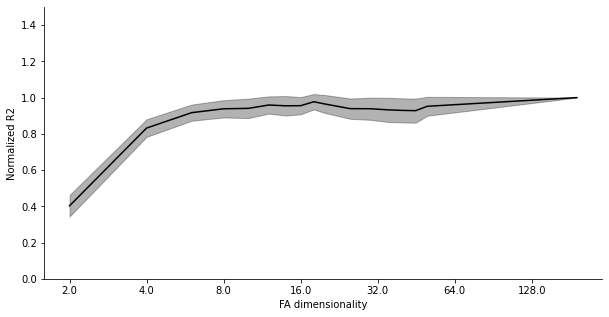

In [61]:
figSize(5, 10)
from matplotlib.ticker import ScalarFormatter

#_ = plt.plot(cfg['FA_dims'], normalized_scores.T, color = 'k', alpha = 0.3)
plotsd(normalized_scores, time_bins= cfg['FA_dims'], color = 'k', alpha = 0.3, toggleSE = True)
plt.ylim([0, 1.5])

ax = plt.gca()
ax.set_xscale('log', base=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

plt.xlabel("FA dimensionality")
plt.ylabel('Normalized R2')